# Introduction

**According to the article, "A Study on Sentiment Analysis of Mental Illness Using Machine Learning Techniques" by Pradeep Kumar Tiwari, Muskan Sharma, Payal Garg, Tarun Jain, Vivek Kumar Verma and Afzal Hussain (https://iopscience.iop.org/article/10.1088/1757-899X/1099/1/012043/pdf)**,

*In the digital age, social media plays a crucial role in society. Social media provides a platform to youth for exchanging their views on public issues and express their personal issues. Hence online media can be used for studying the behavior of people. Applying sentiment analysis on the data obtained timely from social networking sites, depression, anorexia, and other
similar mental illness can be predicted among youth. The importance of detecting depression is that it is the root cause of a plethora of diseases. Early prediction can also mitigate the number of suicides. This work is to detect depression and PTSD (Post Traumatic Stress Disorder) among the Twitter users. Analysing the tweets, how likely a person is to suffer from any of the aforementioned diseases can be discovered.*

![R82595353_g.jpg](attachment:bc531fc4-de4f-482b-b23b-1a6ff543dddf.jpg)

image from https://www.openpr.com/news/1201280/sentiment-analysis-software-market-global-industry-analysis-2018-popular-trends-technological-advancements-to-watch-out-for-near-future.html

**In this notebook, I tried three models,**
* Naive Bayes
* Random Forest Classifier
* LSTM

**to classify emotion from text.**

reference
* "A Study on Sentiment Analysis of Mental Illness Using Machine Learning Techniques" by Pradeep Kumar Tiwari, Muskan Sharma, Payal Garg, Tarun Jain, Vivek Kumar Verma and Afzal Hussain (https://iopscience.iop.org/article/10.1088/1757-899X/1099/1/012043/pdf),
* "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

# Importing

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import string
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scikitplot.metrics import plot_confusion_matrix, plot_roc
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from google.colab import drive
import time
import nltk
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from tensorflow.keras.layers import  GRU
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential, load_model
from keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping

# Data Outline

**1) The first 5 lines in data**

In [ ]:

drive.mount('/content/drive')
# Define the path to the dataset file
file_path = "/content/drive/MyDrive/Colab Notebooks/project/twitter_data.csv"
# Load the dataset using pandas
data = pd.read_csv(file_path)
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


**2) Data shape**

In [ ]:
print(data.shape)

(27977, 2)


**3) Null in data**

In [ ]:
data.isnull().sum()

text     0
label    0
dtype: int64

**4) The number by labels**

In [ ]:
data['label'].value_counts()

0    14139
1    13838
Name: label, dtype: int64

**5) Bar and Pie plot by '0' and '1'**

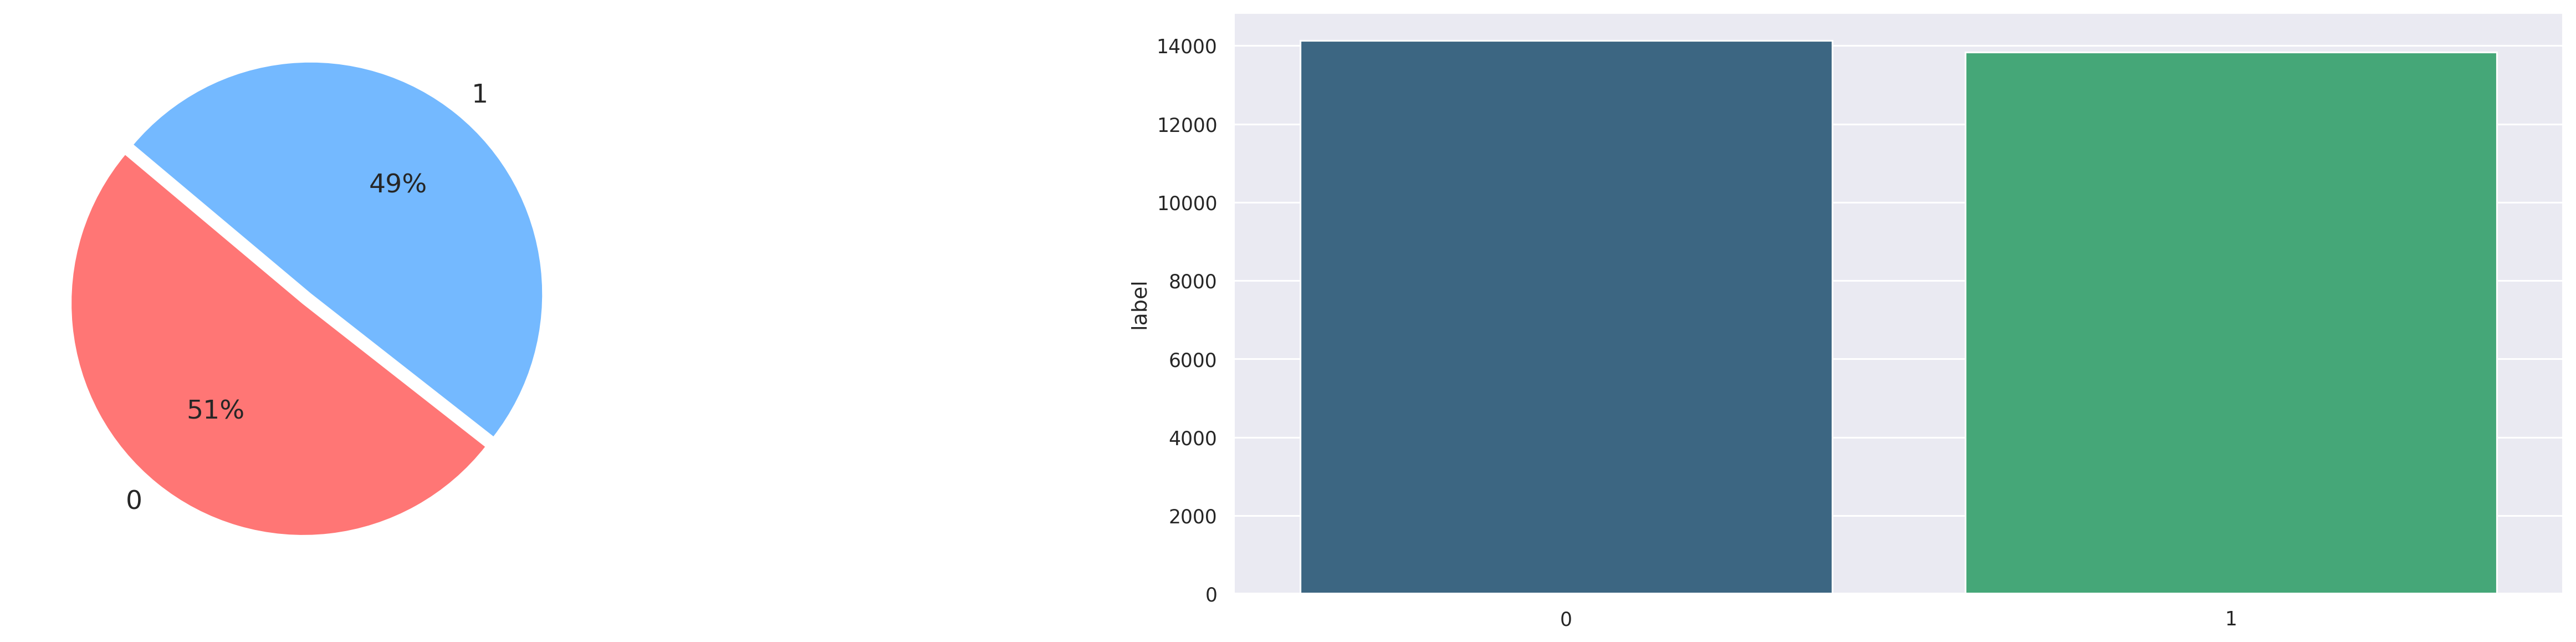

In [ ]:


labels = [0, 1]
sizes = [14139, 13838]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(30, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140,
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1, 2, 2)
sns.barplot(x = data['label'].unique(), y = data['label'].value_counts(), palette= 'viridis')

plt.show()

**6) Creating new columns 'Total Words' and 'Total Chars'**

In [ ]:
data['Total Words'] = data['text'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["text"].apply(count_total_words)

In [ ]:
data.head()

,text,label,Total Words,Total Chars
0,dear american teens question dutch person hear...,0,23,112
1,nothing look forward lifei dont many reasons k...,1,20,98
2,music recommendations im looking expand playli...,0,64,387
3,im done trying feel betterthe reason im still ...,1,100,493
4,worried year old girl subject domestic physic...,1,311,1819


# Text preprocessing

**1) Lowercasing**

In [ ]:
def convert_lowercase(text):
    text = text.lower()
    return text

data['text'] = data['text'].apply(convert_lowercase)

**2) Removing URLs**

In [ ]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['text'] = data['text'].apply(remove_url)

**3) Removing Punctuations**

In [ ]:
exclude = string.punctuation
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))
data['text'] = data['text'].apply(remove_punc)

**4) Removing stopwords**

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data['text'] = data['text'].apply(remove_stopwords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**5) Stemming**

In [ ]:
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['text'] = data['text'].apply(perform_stemming)

**6) Creating new column 'Total Words After Transformation'**

In [ ]:
data['Total Words After Transformation'] = data['text'].apply(lambda x: np.log(len(x.split())))

In [ ]:
data.head()

,text,label,Total Words,Total Chars,Total Words After Transformation
0,dear american teen question dutch person heard...,0,23,112,3.135494
1,noth look forward lifei dont mani reason keep ...,1,20,98,2.944439
2,music recommend im look expand playlist usual ...,0,64,387,4.110874
3,im done tri feel betterth reason im still aliv...,1,100,493,4.574711
4,worri year old girl subject domest physicalmen...,1,311,1819,5.690359


# Data Visualization

**1) Word Cloud by label '0'**

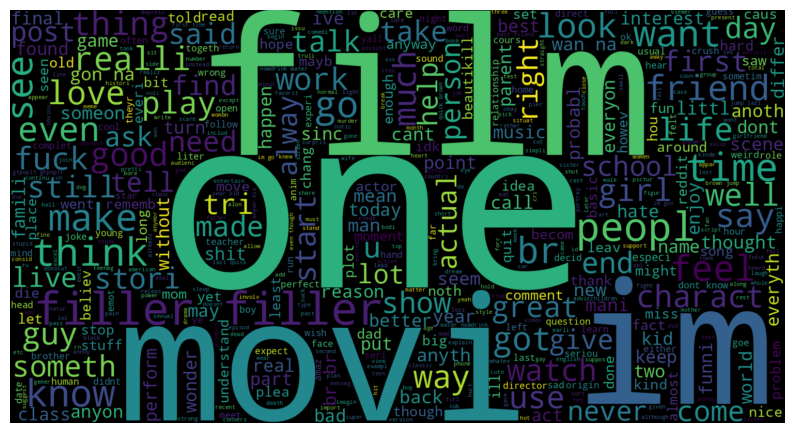

In [ ]:
text = " ".join(data[data['label'] == 0]['text'])
plt.figure(figsize = (10, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**2) Word Cloud by label '1'**

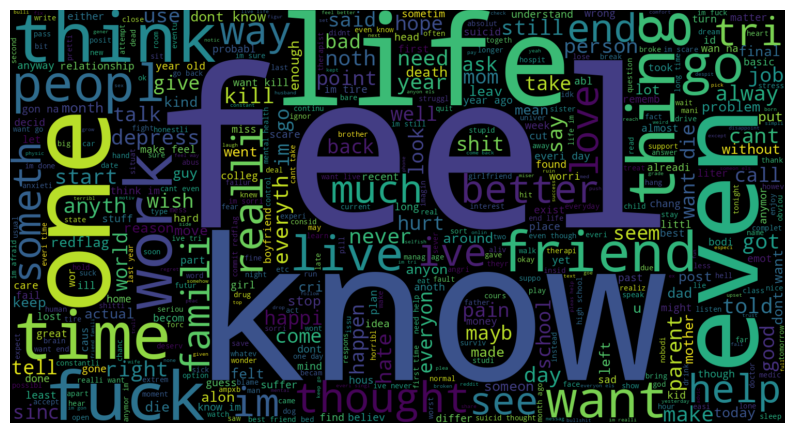

In [ ]:
text = " ".join(data[data['label'] == 1]['text'])
plt.figure(figsize = (10, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**3) Word Frequency by label '0'**

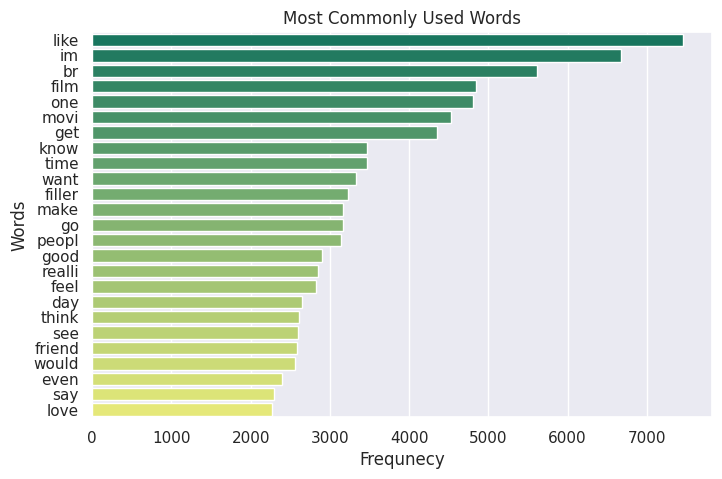

In [ ]:
all_spam_words = []
for sentence in data[data['label'] == 0]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1)
plt.figure(figsize=(8,5))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

**4) Word Frequency by label '1'**

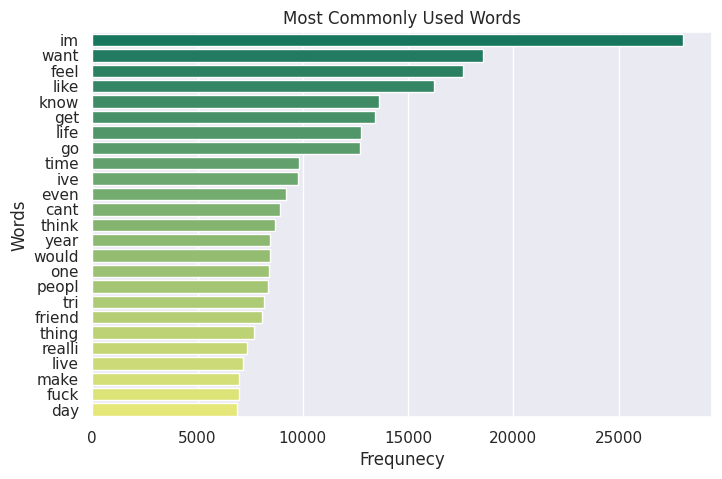

In [ ]:
all_spam_words = []
for sentence in data[data['label'] == 1]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1)
plt.figure(figsize=(8,5))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

# Modeling

                                                                  
#                                                                  **ConvBILSTM**







In [ ]:
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [ ]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', data['text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(data['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 dear american teen question dutch person heard guy get way easier thing learn age us sooooo thth grader like right guy learn math 

After Tokenization & Padding 
 [1890  719  805  288 4306   68  558  108    5   37  771   21  338  344
  158    2   71  108  338 1028    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
y = data.label
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (15666, 100) (15666,)
Validation Set: (6715, 100) (6715,)
Test Set:       (5596, 100) (5596,)


In [ ]:
vocab_size = 5000
embedding_size = 32
epochs=10

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(),'accuracy'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 32)           160000    
                                                                 
 conv1d_11 (Conv1D)          (None, 100, 64)           6208      
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 50, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_12 (Conv1D)          (None, 50, 128)           24704     
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 25, 128)           0         
 ng1D)                                                           
                                                                 
 bidirectional_14 (Bidirect  (None, 25, 256)         

In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/10
245/245 [==============================] - 63s 222ms/step - loss: 0.3094 - recall_8: 0.8751 - accuracy: 0.8708 - val_loss: 0.2256 - val_recall_8: 0.9109 - val_accuracy: 0.9132
Epoch 2/10
245/245 [==============================] - 52s 214ms/step - loss: 0.1793 - recall_8: 0.9393 - accuracy: 0.9346 - val_loss: 0.2184 - val_recall_8: 0.9247 - val_accuracy: 0.9148
Epoch 3/10
245/245 [==============================] - 47s 193ms/step - loss: 0.1375 - recall_8: 0.9603 - accuracy: 0.9512 - val_loss: 0.2376 - val_recall_8: 0.9262 - val_accuracy: 0.9138
Epoch 4/10
245/245 [==============================] - 48s 197ms/step - loss: 0.1046 - recall_8: 0.9707 - accuracy: 0.9647 - val_loss: 0.3448 - val_recall_8: 0.9027 - val_accuracy: 0.9059
Epoch 5/10
245/245 [==============================] - 48s 198ms/step - loss: 0.0819 - recall_8: 0.9800 - accuracy: 0.9743 - val_loss: 0.3089 - val_recall_8: 0.9036 - val_accuracy: 0.9023
Epoch 6/10
245/245 [==============================] - 52s 212ms/s

In [ ]:
loss, accuracy,recall= model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))
print('Recall  : {:.4f}'.format(recall))

Accuracy  : 0.9129
Recall  : 0.9001


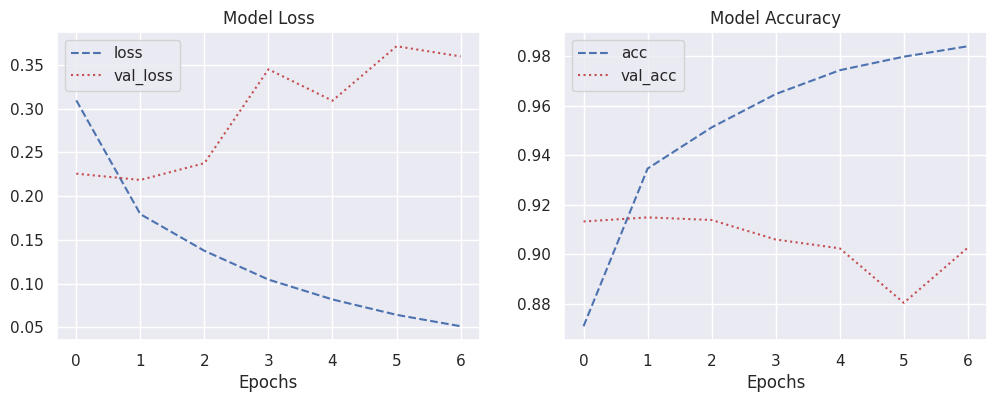

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

175/175 [==============================] - 9s 38ms/step


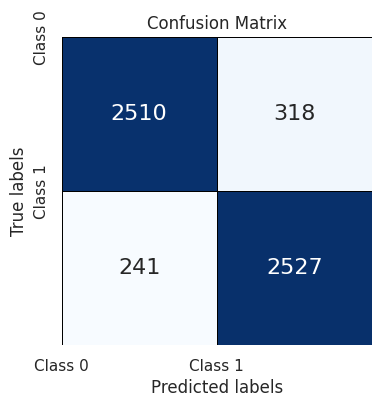

In [ ]:
y_pred = model.predict(X_tst)  # Replace with your model's predictions
y_true = y_tst  # Replace with your true labels

# Calculate the confusion matrix
cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int))
plt.figure(figsize=(4,4))
sns.set(font_scale=1)  # Adjust the font size if needed
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black')

# Customize labels, title, and axis ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
plt.yticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])

plt.show()

In [ ]:
# Import necessary libraries for classification report
from sklearn.metrics import classification_report

# ... Rest of your code ...

# After obtaining predictions on test data
y_pred_prob = model.predict(X_tst)
threshold = 0.5  # You can adjust this threshold as needed
y_pred = (y_pred_prob > threshold).astype(int)

# Calculate and print the classification report
print(classification_report(y_tst, y_pred))


175/175 [==============================] - 10s 57ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2828
           1       0.89      0.91      0.90      2768

    accuracy                           0.90      5596
   macro avg       0.90      0.90      0.90      5596
weighted avg       0.90      0.90      0.90      5596



▶ COMPARE COVBILSTM WITH OTHER MODEL




# **Gated Recurrent Unit(GRU)**

In [ ]:
vocab_size = 5000
embedding_size = 32
epochs=10

gru_model= Sequential()
gru_model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
gru_model.add(GRU(64, activation='relu', return_sequences=True),)
gru_model.add(GRU(32, activation='relu'),)
gru_model.add(Dense(1, activation='sigmoid'))



In [ ]:
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(),'accuracy'])
print(gru_model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 100, 32)           160000    
                                                                 
 gru_8 (GRU)                 (None, 100, 64)           18816     
                                                                 
 gru_9 (GRU)                 (None, 32)                9408      
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                                 
Total params: 188257 (735.38 KB)
Trainable params: 188257 (735.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

gru_history = gru_model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/10
245/245 [==============================] - 30s 110ms/step - loss: 0.4968 - recall_13: 0.5954 - accuracy: 0.7430 - val_loss: 0.2680 - val_recall_13: 0.9359 - val_accuracy: 0.8938
Epoch 2/10
245/245 [==============================] - 26s 108ms/step - loss: 0.2160 - recall_13: 0.9162 - accuracy: 0.9191 - val_loss: 0.2159 - val_recall_13: 0.9274 - val_accuracy: 0.9153
Epoch 3/10
245/245 [==============================] - 26s 105ms/step - loss: 0.1617 - recall_13: 0.9413 - accuracy: 0.9413 - val_loss: 0.2189 - val_recall_13: 0.9130 - val_accuracy: 0.9172
Epoch 4/10
245/245 [==============================] - 27s 111ms/step - loss: 0.1367 - recall_13: 0.9520 - accuracy: 0.9510 - val_loss: 0.2245 - val_recall_13: 0.9051 - val_accuracy: 0.9145
Epoch 5/10
245/245 [==============================] - 26s 106ms/step - loss: 0.1104 - recall_13: 0.9634 - accuracy: 0.9625 - val_loss: 0.2520 - val_recall_13: 0.9094 - val_accuracy: 0.9118
Epoch 6/10
245/245 [==============================] - 2

In [ ]:
loss, accuracy,recall= gru_model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))
print('Recall  : {:.4f}'.format(recall))

Accuracy  : 0.8851
Recall  : 0.9026


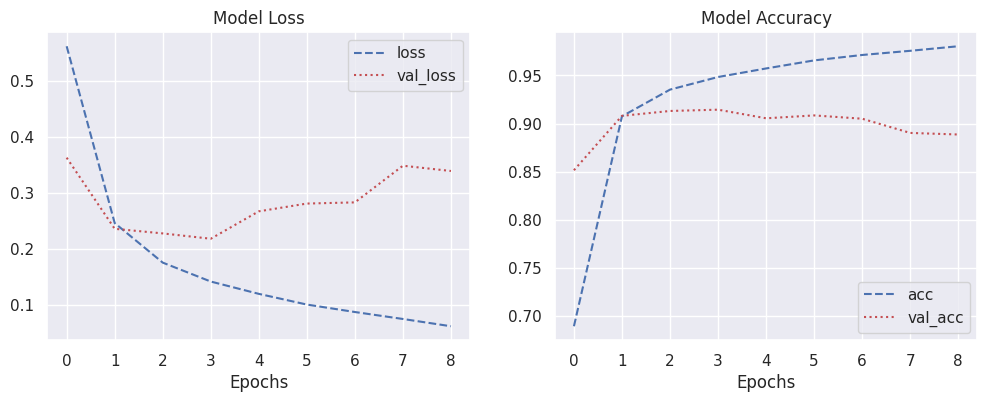

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(gru_history.history['loss'], 'b--', label = 'loss')
plt.plot(gru_history.history['val_loss'], 'r:', label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gru_history.history['accuracy'], 'b--', label = 'acc')
plt.plot(gru_history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

175/175 [==============================] - 5s 26ms/step


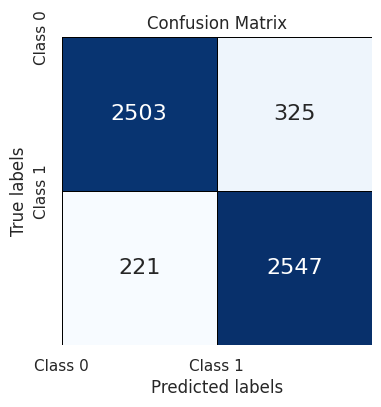

In [ ]:
gru_y_pred = gru_model.predict(X_tst)  # Replace with your model's predictions
gru_y_true = y_tst  # Replace with your true labels

# Calculate the confusion matrix
cm = confusion_matrix(y_true, (gru_y_pred > 0.5).astype(int))
plt.figure(figsize=(4,4))
sns.set(font_scale=1)  # Adjust the font size if needed
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black')

# Customize labels, title, and axis ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
plt.yticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])

plt.show()

In [ ]:
# Import necessary libraries for classification report
from sklearn.metrics import classification_report

# ... Rest of your code ...

# After obtaining predictions on test data
y_pred_prob = gru_model.predict(X_tst)
threshold = 0.5  # You can adjust this threshold as needed
y_pred = (y_pred_prob > threshold).astype(int)

# Calculate and print the classification report
print(classification_report(y_tst, y_pred))


175/175 [==============================] - 3s 18ms/step
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2828
           1       0.92      0.89      0.90      2768

    accuracy                           0.90      5596
   macro avg       0.90      0.90      0.90      5596
weighted avg       0.90      0.90      0.90      5596

